In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from src.prediction_functions import *
from scipy.stats import ttest_ind
from scipy.stats import pearsonr


In [3]:
from src.config import *
from src.prediction_functions.MatrixMultiplicationMemoryEffectiveChunks import estimate_receptor_activity


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import decoupler as dc


/Users/basvaat/opt/anaconda3/envs/py311_ccc_decoupler/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read in data

In [6]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)

In [7]:
confidence_metric = 'mwu_pvalue'# 'ROCAUC'

In [8]:
lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col =0)
lincs_model = lincs_model.T

In [9]:
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]
lr_associations_receptor = lr_associations[lr_associations['target_genesymbol'].isin(lincs_model.columns)]

In [10]:
cytosig_data = pd.read_csv(f'data/cytosig/diff.merge.gz', compression='gzip', sep = '\t')
cytosig_data = cytosig_data.T

# Prediction

In [11]:
# axis= 1 -> columns
cytosig_data_notna = cytosig_data.dropna(axis = 1, thresh= 0.95*cytosig_data.shape[0]).fillna(0)
cytosig_data_notna.shape

(2056, 8021)

In [12]:
receptor_activity = estimate_receptor_activity(cytosig_data_notna, lincs_model, number_of_permutations=100, chunk_size=300)
# receptor_activity = pd.read_csv('results/temp/lincs_cytosig_prediction_filteredsignatures.csv', index_col = 0)

Number of samples: 2056
Number of chunks: 7
Number of permutations: 100


100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


In [13]:
# tf_net = dc.get_collectri(organism='human', split_complexes=True)
dorothea = dc.get_dorothea(levels = ['A', 'B', 'C'])

In [14]:
tf_acts, tf_pvals = dc.run_consensus(mat=cytosig_data_notna, net=dorothea)


# KEGG

In [15]:
with open(f'data/genesets/c2.cp.kegg.v2023.1.Hs.symbols.gmt') as gmt:
    file_contents = (gmt.read())

In [16]:
file_contents = file_contents.split('\n')
file_contents = file_contents[:-1]
kegg_pws = {}
for line in file_contents:
    elements = line.split('\t')  # Split each line into elements using '\t' as the separator
    id_ = elements[0]  # First element is the ID
    elements_list = elements[2:]  # Elements starting from the third element
    kegg_pws[id_] = elements_list

In [17]:
receptors = list(receptor_activity.columns)
len(receptors)

229

In [18]:
tfs = list(tf_acts.columns)
len(tfs)

280

In [19]:
pairs = {}
for receptor in receptors:
    for tf in tfs:
        cnt = 0
        for pw in kegg_pws:
            proteinlist = kegg_pws[pw]
            if tf in proteinlist and receptor in proteinlist:
                cnt += 1
        pairs[receptor+'_'+tf] = cnt
        

In [20]:
pairs_yesno = {key: (1 if value >= 1 else 0) for key, value in pairs.items()}


In [23]:
correlation_matrix = pd.DataFrame(index=receptor_activity.columns, columns=tf_acts.columns)

for receptor in receptor_activity.columns:
    for tf in tf_acts.columns:
        correlation_matrix.loc[receptor, tf] = pearsonr(receptor_activity[receptor], tf_acts[tf])[0]
correlation_matrix = correlation_matrix.apply(pd.to_numeric)
# if the receptor is inactive: tf should be 0
# if the receptor is 0: tf should be 0
# if the receptor is active: tf should be high or low. (abs)

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_93917/1414747481.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Correlation', x='Pair', data=boxplot_data, palette = 'Blues', showfliers=False)


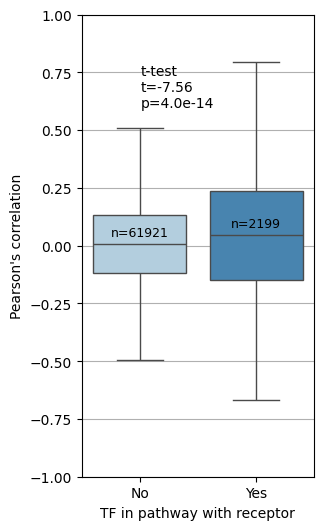

In [24]:

data = []
for pair, value in pairs_yesno.items():
    receptor, tf = pair.split('_', 1)
    if value == 1:
        data.append((receptor, tf, 1, correlation_matrix.loc[receptor, tf]))
    else:
        data.append((receptor, tf, 0, correlation_matrix.loc[receptor, tf]))

boxplot_data = pd.DataFrame(data, columns=['Receptor', 'TF', 'Pair', 'Correlation'])

group_0 = boxplot_data[boxplot_data['Pair'] == 0]['Correlation']
group_1 = boxplot_data[boxplot_data['Pair'] == 1]['Correlation']
inpw = group_1
outpw = group_0

fig, ax = plt.subplots(figsize=(3, 6))
sns.boxplot(y='Correlation', x='Pair', data=boxplot_data, palette = 'Blues', showfliers=False)

ax.text(0, np.median(outpw)+0.05, 'n='+str(len(outpw)), ha='center', va='center', color='k', fontsize=9)
ax.text(1, np.median(inpw)+0.05, 'n='+str(len(inpw)), ha='center', va='center', color='k', fontsize=9)
ttestres = ttest_ind(outpw, inpw)
ax.text(0.01, 0.6, str("t-test\nt="+"{:.2f}".format(ttestres[0])+"\np="+"{:.1e}".format(ttestres[1])), ha='left')

plt.xlabel('TF in pathway with receptor')
plt.grid(axis='y')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Pearson\'s correlation')
plt.ylim(-1, 1)
plt.savefig('figures/revision/kegg_pw_abstfa_reca_correlation_boxplot.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/revision/kegg_pw_abstfa_reca_correlation_boxplot.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/revision/kegg_pw_abstfa_reca_correlation_boxplot.jpg', dpi=300, bbox_inches='tight')
plt.show()